# Titanic - Machine Learning from Disaster
Start here! Predict survival on the Titanic and get familiar with ML basics  
kaggle: https://www.kaggle.com/c/titanic

## 環境設定
--------
## 環境設定
- GPU の使用状況を確認
- Google ドライブに接続
- パッケージ・ランダムシード設定

In [2]:
# GPU確認
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
# 連接雲端硬碟
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabData/Titanic
#!unzip 'titanic.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabData/Titanic


In [2]:
# 套件，random seed
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm
import math
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.autograd import Variable
import time
import copy

Random_seed = 57
np.random.seed(Random_seed)
random.seed(Random_seed)
%matplotlib inline

## 讀檔、預處理
----------------------------
## データ準備
- データの読み込み
- データ全体の規模・変数を見る

### 讀檔

In [3]:
df_tnc_train = pd.read_csv('train.csv')
df_tnc_test = pd.read_csv('test.csv')
df_tnc = pd.concat([df_tnc_train, df_tnc_test])

### 資料大小、欄位資訊

In [4]:
print('train data:', df_tnc_train.shape, ', test data:', df_tnc_test.shape)
df_tnc_train.info()

train data: (891, 12) , test data: (418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 特徵工程(1)
-------
## 特徴量エンジニアリング(1)
 * 性別 -> ダミー変数
 * 新特徴量：名前の長さ（単語数）

In [ ]:
# 把性別變成數值
df_tnc['Male'] = df_tnc['Sex'].apply(lambda x: 1 if x == 'male' else 0)

# 製造特徵: 姓名長度(單字數)
df_tnc['Name_len'] = df_tnc['Name'].apply(lambda x: len(x.split()))

## EDA
-------
## EDA
 * 生存状況分布
 * 相関係数相関係数
 * 欠損値状況
 * 数値データ分布

In [ ]:
# 切割出訓練資料
df_tnc_train = df_tnc[df_tnc['Survived'].isna() == False]

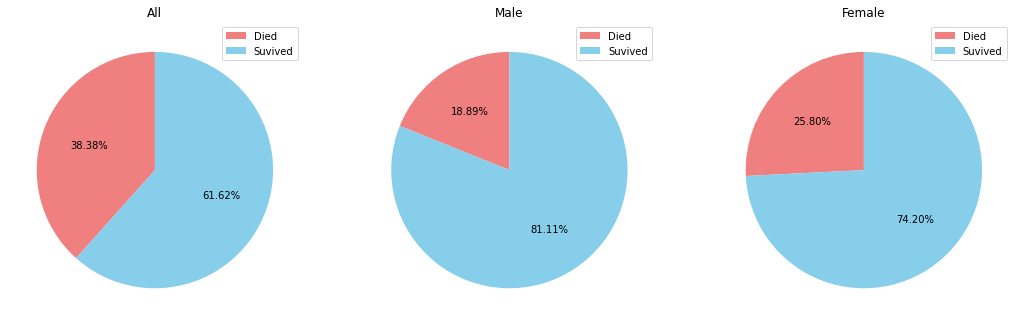

<Figure size 432x288 with 0 Axes>

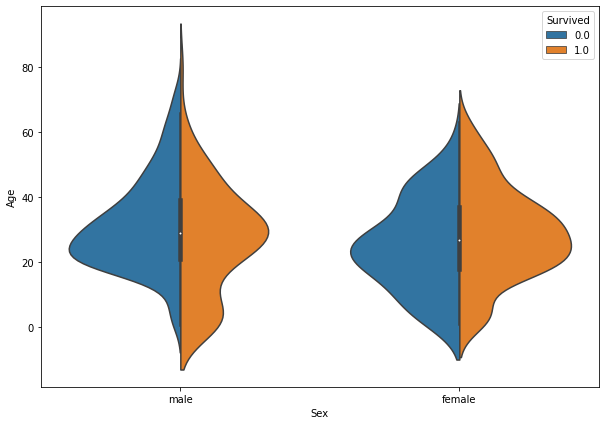

<Figure size 432x288 with 0 Axes>

In [ ]:
# 存活結果分布

plt.figure(figsize = (18, 6))
plt.subplot(1, 3, 1)
plt.pie(df_tnc_train['Survived'].value_counts().sort_values(),
    autopct = "%1.2f%%", startangle=90, colors=['lightcoral','skyblue'])
plt.title('All')
plt.legend(['Died', 'Suvived'])

plt.subplot(1, 3, 2)
plt.pie(df_tnc_train[df_tnc_train['Sex'] == 'male']['Survived'].value_counts().sort_values(),
    autopct = "%1.2f%%", startangle=90, colors=['lightcoral','skyblue'])
plt.title('Male')
plt.legend(['Died', 'Suvived'])

plt.subplot(1, 3, 3)
plt.pie(df_tnc_train[df_tnc_train['Sex'] == 'female']['Survived'].value_counts().sort_values(),
    autopct = "%1.2f%%", startangle=90, colors=['lightcoral','skyblue'])
plt.title('Female')
plt.legend(['Died', 'Suvived'])
plt.show()
plt.savefig('./img/pie.png')

plt.figure(figsize = (10, 7))
sns.violinplot(x = 'Sex', y = 'Age', hue = 'Survived', data = df_tnc_train, split = True)
plt.show()
plt.savefig('./img/violin.png')

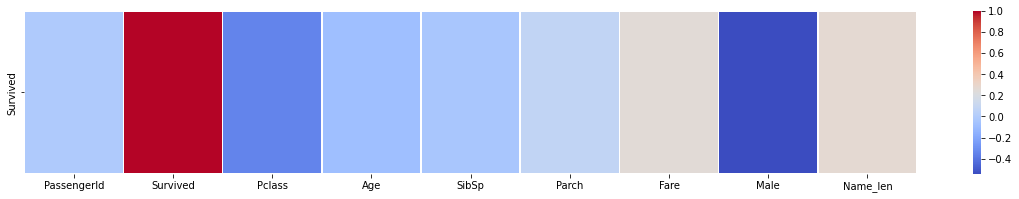

In [ ]:
# 相關係數熱圖

f, ax = plt.subplots(figsize=(20, 3))
mat = df_tnc_train.corr('pearson')
sns.heatmap(mat.sort_values(by=['Survived'], ascending=False).head(1), cmap='coolwarm', linewidths=.5)
plt.savefig('./img/corr.png')

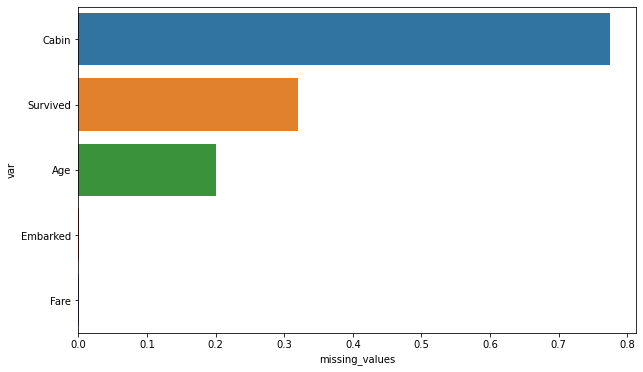

In [ ]:
# 遺漏值情形

df_na = DataFrame(df_tnc.isna().mean().sort_values(ascending=False)).reset_index()
df_na.columns = ['var', 'missing_values']
df_na = df_na[df_na['missing_values'] > 0]

fig,ax=plt.subplots(figsize=(10, 6))
sns.barplot(x='missing_values',y='var',data=df_na)
plt.savefig('./img/na.png')

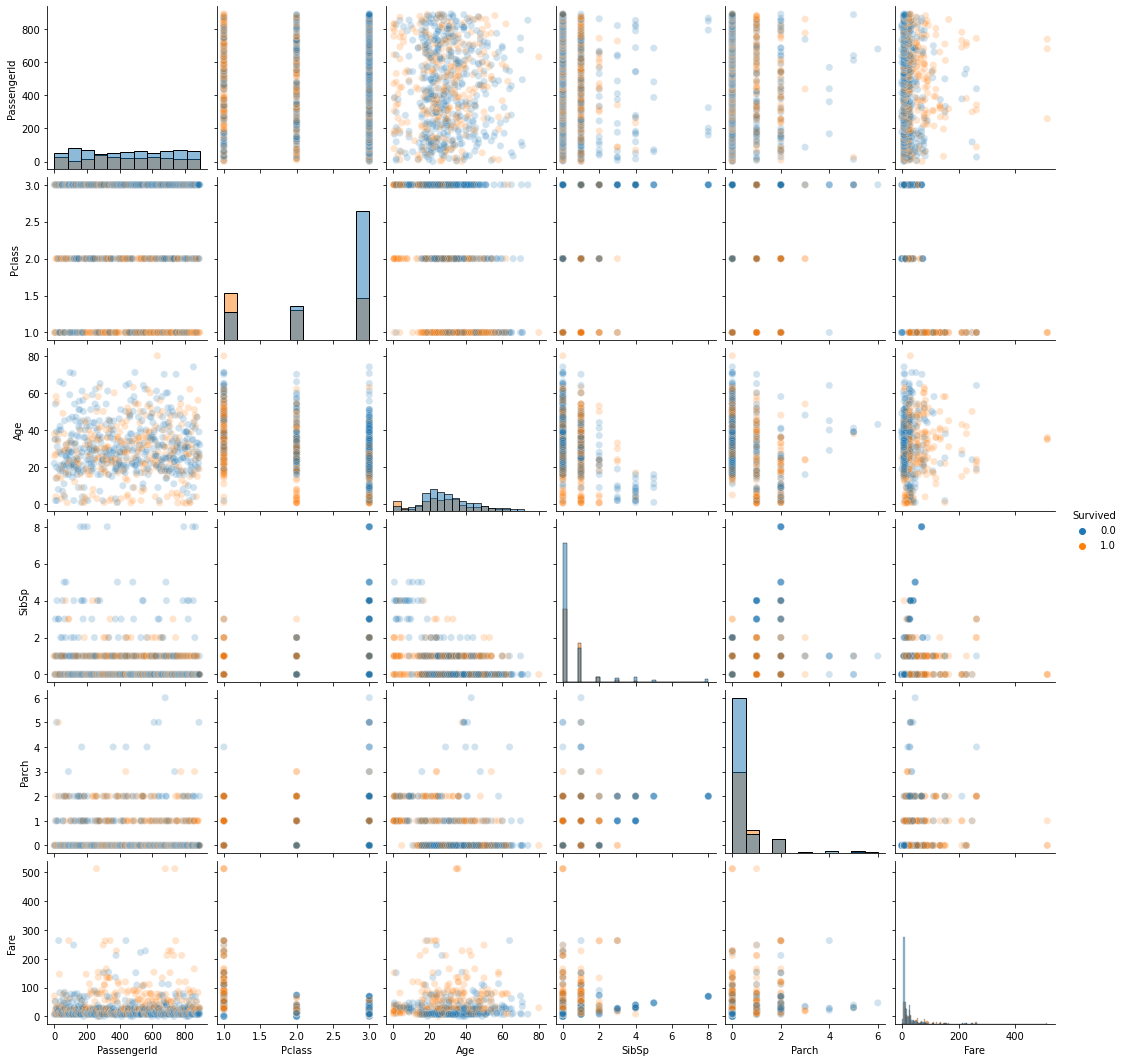

<Figure size 432x288 with 0 Axes>

In [ ]:
# 數值欄位分布

df_num_var = df_tnc_train.iloc[:, :-4].select_dtypes(['int64','float64'])
sns.pairplot(df_num_var, kind="scatter", diag_kind="hist", hue='Survived',
             plot_kws=dict(s=50,edgecolor="w",color="g",alpha=.2))
plt.show()
plt.savefig('./img/pairplot.png')

## 處理遺漏值
-------
## 欠損値を埋める

In [ ]:
# 遺漏值處理

## 移除遺漏值太多的欄位
df_tnc = df_tnc.drop(columns=['Cabin'], axis=1)

## 類別欄位補 none
df_tnc['Embarked'] = df_tnc['Embarked'].fillna('none')

## Fare補 df_train平均數
df_tnc['Fare'] = df_tnc['Fare'].fillna(df_tnc_train['Fare'].mean())

## 年齡欄位補 none
df_tnc['Age'] = df_tnc['Age'].fillna('none')

## 特徵工程(2)
-------
## 特徴量エンジニアリング(2)
 * 年齢データをグループに分けて、ダミー変数にする
 * カテゴリ変数をダミー変数に(One-Hot Encoding)
 * 新特徴：身分を表する単語（Mr., Mrsなど）


In [ ]:
# 把年齡分成組別

def to_age_group(x):
  if x == 'none':
    return x
  elif x < 5:
    group = '0-4'
    return group
  elif (x >= 5) & (x < 15):
    group = '5-14'
    return group
  elif (x >= 15) & (x < 20):
    group = '15-19'
    return group
  elif (x >= 20) & (x < 30):
    group = '20-29'
    return group
  elif (x >= 30) & (x < 40):
    group = '30-39'
    return group
  elif (x >= 40) & (x < 50):
    group = '40-49'
    return group
  elif (x >= 50) & (x < 60):
    group = '50-59'
    return group
  elif x >= 60:
    group = 'over60'
    return group


df_tnc['Age_group'] = df_tnc['Age'].apply(lambda x: to_age_group(x))

In [ ]:
# One-Hot Encoding

cate_var = ['Age_group', 'Pclass', 'Embarked']
df_tnc = pd.get_dummies(df_tnc, columns=cate_var , prefix=cate_var)

In [ ]:
# 製造特徵: 姓名稱謂字

for i in ['Mr.', 'Mrs.', 'Miss.', 'Master.'] :
  df_tnc[i] = df_tnc['Name'].apply(lambda x : 1 if i in x else 0)
  #result = df_tnc[df_tnc[i] == 1]['Survived']
  #print(i, result.mean(), result.count())

In [ ]:
# 刪除多餘欄位、儲存處理後資料

df_tnc = df_tnc.drop(columns=['Name', 'Sex', 'Ticket', 'Age'], axis=1)
df_tnc.to_csv('tnc_data.csv', encoding = 'utf-8-sig', index=0)

## 建模資料準備
-------
## モデル構築の準備
 - データサンプリング
 - 特徴量標準化

In [ ]:
# 切割訓練/測試/驗證集
df_tnc = pd.read_csv('tnc_data.csv')

df_train_valid = df_tnc[df_tnc['Survived'] >= 0]
df_train, df_valid = train_test_split(df_train_valid, test_size=0.15, random_state=Random_seed)
df_test = df_tnc[df_tnc['Survived'].isna()].drop(columns=['Survived'], axis=1)

In [ ]:
# 標準化

sc = StandardScaler()
sc.fit(df_train.drop(columns=['PassengerId', 'Survived']))

X_train_all = sc.transform(df_train_valid.drop(columns=['PassengerId', 'Survived'], axis=1))
y_train_all = df_train_valid['Survived'].values
X_train = sc.transform(df_train.drop(columns=['PassengerId', 'Survived'], axis=1))
y_train = df_train['Survived'].values
X_valid = sc.transform(df_valid.drop(columns=['PassengerId', 'Survived'], axis=1))
y_valid = df_valid['Survived'].values
X_test = sc.transform(df_test.drop(columns=['PassengerId'], axis=1))

In [ ]:
#　各模型的最佳參數與 score

models = {}
preds = {}
scores = {}

## 單一模型
-------
## モデル構築

 * Logistic
 * KNN（+GridSearch）
 * SVM（+GridSearch）
 * Decision Tree（+GridSearch）
 * Random Forest（+GridSearch）

### Logistic

In [ ]:
# Logistic

Log_reg = LogisticRegression(fit_intercept = True, random_state = Random_seed)
Log_reg.fit(X_train, y_train)
models["Log"] = Log_reg

In [ ]:
# 預測及存檔

y_pred = Log_reg.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["Log"] = acc_valid
print('Valid Acc:', acc_valid)

Log_reg.fit(X_train_all, y_train_all)

pred_Log = Log_reg.predict(X_test).astype(int)
preds['Log'] = pred_Log
df_test['Survived'] = pred_Log
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/LogReg.csv', index = 0)

Valid Acc: 0.7835820895522388


### KNN

In [ ]:
# KNN

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['distance', 'uniform'],
        'metric': ['euclidean', 'minkowski']
        }
KNN_grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring= 'accuracy')
KNN_grid.fit(X_train, y_train)
KNN = KNeighborsClassifier(**KNN_grid.best_params_)
KNN.fit(X_train, y_train)

models["KNN"] = KNN
print("best estimator: {}".format(KNN_grid.best_params_))

best estimator: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}


In [ ]:
# 預測及存檔

y_pred = KNN.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["KNN"] = acc_valid
print('Valid Acc:', acc_valid)

KNN.fit(X_train_all, y_train_all)

pred_KNN = KNN.predict(X_test).astype(int)
df_test['Survived'] = pred_KNN
preds['KNN'] = pred_KNN
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/KNN.csv', index = 0)

Valid Acc: 0.8059701492537313


### SVM

In [ ]:
# SVM

param_grid = {'C': [0.1, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'],
        'random_state': [Random_seed],
        'probability': [True]
        }
SVM_grid = GridSearchCV(SVC(), param_grid, scoring= 'accuracy')
SVM_grid.fit(X_train, y_train)
SVM = SVC(**SVM_grid.best_params_)
SVM.fit(X_train, y_train)


models["SVM"] = SVM
print("best estimator: {}".format(SVM_grid.best_params_))

best estimator: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'probability': True, 'random_state': 57}


In [ ]:
# 預測及存檔

y_pred = SVM.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["SVM"] = acc_valid
print('Valid Acc:', acc_valid)

SVM.fit(X_train_all, y_train_all)

pred_SVM = SVM.predict(X_test).astype(int)
df_test['Survived'] = pred_SVM
preds['SVM'] = pred_SVM
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/SVM.csv', index = 0)

Valid Acc: 0.8059701492537313


### Decision Tree

In [ ]:
# Decision Tree

param_grid = {'criterion': ['gini', 'entropy'],
        'splitter': ['best'],
        'max_depth': [2, 3, 4, 5, 6],
        'min_samples_leaf': [4, 5, 6, 8],
        'random_state': [Random_seed],
        }
DTree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring= 'accuracy')
DTree_grid.fit(X_train, y_train)
DTree = DecisionTreeClassifier(**DTree_grid.best_params_)
DTree.fit(X_train, y_train)

models["DTree"] = DTree
print("best estimator: {}".format(DTree_grid.best_params_))

best estimator: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'random_state': 57, 'splitter': 'best'}


In [ ]:
# 預測及存檔

y_pred = DTree.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["DTree"] = acc_valid
print('Valid Acc:', acc_valid)

DTree.fit(X_train_all, y_train_all)

pred_DTree = DTree.predict(X_test).astype(int)
df_test['Survived'] = pred_DTree
preds['DTree'] = pred_DTree
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/DTree.csv', index = 0)

Valid Acc: 0.7985074626865671


### Random Forest

In [ ]:
# Random Forest

param_grid = {'n_estimators': [50],
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3, 4, 5, 6],
        'min_samples_leaf': [4, 5, 6, 8],
        'random_state': [Random_seed],
        }
RF_grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring= 'accuracy')
RF_grid.fit(X_train, y_train)
RF = RandomForestClassifier(**RF_grid.best_params_)
RF.fit(X_train, y_train)

models["RF"] = RF
print("best estimator: {}".format(RF_grid.best_params_))

best estimator: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 4, 'n_estimators': 150, 'random_state': 57}


In [ ]:
# 預測及存檔

y_pred = RF.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["RF"] = acc_valid
print('Valid Acc:', acc_valid)

RF.fit(X_train_all, y_train_all)

pred_RF = RF.predict(X_test).astype(int)
df_test['Survived'] = pred_RF
preds['RF'] = pred_RF
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/RF.csv', index = 0)

Valid Acc: 0.8059701492537313


## 集成模型
-------
## ブレンド方法
 * Voting
 * Stacking

### Voting

In [ ]:
# Voting

model_list = [('Log', models['Log']), ('KNN', models['KNN']), ('SVM', models['SVM']), ('DTree', models['DTree']), ('RF', models['RF'])]

param_grid = {'estimators': [model_list],
        'voting': ['hard', 'soft']}

Voting_grid = GridSearchCV(VotingClassifier(model_list), param_grid, scoring= 'accuracy')
Voting_grid.fit(X_train, y_train)
Voting_model = VotingClassifier(**Voting_grid.best_params_)
Voting = Voting_model.fit(X_train, y_train)
models["Voting"] = Voting
print("best estimator: {}".format(Voting_grid.best_params_))

best estimator: {'estimators': [('Log', LogisticRegression(random_state=57)), ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=7)), ('SVM', SVC(C=0.1, kernel='linear', probability=True, random_state=57)), ('DTree', DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, random_state=57)), ('RF', RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=10,
                       random_state=57))], 'voting': 'soft'}


In [ ]:
# 預測及存檔

y_pred = Voting.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["Vote"] = acc_valid
print('Valid Acc:', acc_valid)

Voting.fit(X_train_all, y_train_all)

pred_Voting = Voting.predict(X_test).astype(int)
df_test['Survived'] = pred_Voting
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Voting.csv', index = 0)

Valid Acc: 0.8134328358208955


### Stacking

In [ ]:
# Stacking

model_list = [('Log', models['Log']), ('KNN', models['KNN']), ('SVM', models['SVM']), ('DTree', models['DTree']), ('RF', models['RF'])]

param_grid = {'estimators': [model_list],
        'final_estimator': [LogisticRegression(fit_intercept = True, random_state = Random_seed),
                   SVC(random_state = Random_seed)
                   ]}

Stacking_grid = GridSearchCV(StackingClassifier(model_list), param_grid, scoring= 'accuracy')
Stacking_grid.fit(X_train, y_train)
Stacking_model = StackingClassifier(**Stacking_grid.best_params_)
Stacking = Stacking_model.fit(X_train, y_train)
models["Stacking"] = Stacking
print("best estimator: {}".format(Stacking_grid.best_params_))

best estimator: {'estimators': [('Log', LogisticRegression(random_state=57)), ('KNN', KNeighborsClassifier(metric='euclidean', n_neighbors=7)), ('SVM', SVC(C=0.1, kernel='linear', probability=True, random_state=57)), ('DTree', DecisionTreeClassifier(max_depth=4, min_samples_leaf=4, random_state=57)), ('RF', RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=10,
                       random_state=57))], 'final_estimator': LogisticRegression(random_state=57)}


In [ ]:
# 預測及存檔

y_pred = Stacking.predict(X_valid).astype(int)
acc_valid = accuracy_score(y_valid, y_pred)
scores["Stacking"] = acc_valid
print('Valid Acc:', acc_valid)

Stacking.fit(X_train_all, y_train_all)

pred_Stacking = Stacking.predict(X_test).astype(int)
df_test['Survived'] = pred_Stacking
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Stacking.csv', index = 0)

Valid Acc: 0.8134328358208955


## Pytorch: NN model
-------
## Neural Networkモデル
 -  Model:　Linear + Dropout + ReLU + sigmoid
 - optimizer: (1)SGD + momentum + weight_decay、(2)Adam、(3)AdamW
 - ブレンド：Voting

### Neural Network Model

In [6]:
# Model

class NeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 1200),
            nn.Dropout(p=0.1),
            nn.ReLU(),
            nn.Linear(1200, 240),
            nn.ReLU(),
            nn.Linear(240, 2)
        )

    def forward(self, x):
        net_x = self.net(x)
        net_x = torch.sigmoid(net_x)
        #print(net_x)
        return net_x

### Hyper-parameters

In [ ]:
# Hyper-parameters

learning_rate = 0.0001
momentum = 0.95
weight_decay = 0.000001
batch_size = 60
n_jobs = 4
n_epochs = 1000
patience = 200
save_path = 'models/NN.pth'
#device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

### Data
 * Dataset
 * DataLoader


In [ ]:
# Dataset

class DataSet(Dataset):
  def __init__(self, X, Y):

    self.X = X
    self.Y = Y
    self.length = len(X)

  def __len__(self):

    return self.length

  def __getitem__(self, index):

    x = self.X[index]
    y = self.Y[index]

    return x, y

In [ ]:
# DataLoader

trainset = DataSet(X_train, y_train)
trainallset = DataSet(X_train_all, y_train_all)

trainloader = DataLoader(trainset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)
trainallloader = DataLoader(trainallset, batch_size = batch_size, num_workers = n_jobs, shuffle = True)

### Train & Predict

In [ ]:
# Train

model = NeuralNet(X_train.shape[1])

#optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)

best_acc = 0
best_epochs = n_epochs
early_stop = False
early_stop_cnt = 0
since = time.time()
for epoch in range(n_epochs):

  model.train()
  for data in trainloader:

      x, y = data[0].float(), data[1].long()

      optimizer.zero_grad()
      output = model(x)
      _, pred = torch.max(output, 1)
      #print(pred, y.squeeze(0))

      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

  train_acc = accuracy_score(y, pred)


  model.eval()
  with torch.no_grad():
    out = model(torch.tensor(X_valid).float())
    _, pred = torch.max(out, 1)

  valid_acc = accuracy_score(torch.tensor(y_valid), pred)

  print('Epoch {}/{}'.format(epoch+ 1, n_epochs))
  print('Train Acc: {:.8f}, Valid Acc: {:.8f}'.format(train_acc, valid_acc))

  if valid_acc > best_acc:
    best_acc = valid_acc
    best_epochs = epoch
    torch.save(model.state_dict(), save_path)

    print('Saving The Model')
    early_stop_cnt = 0
  else:
    print("Counter {} of {}".format(early_stop_cnt+ 1, patience))
    early_stop_cnt += 1

  print('-' * 10)

  if early_stop_cnt >= patience:
    print("Early stop!")
    early_stop = True

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:.8f}, epoch {}'.format(best_acc, best_epochs))
    break

if early_stop == False:

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best valid Acc: {:.8f}'.format(best_acc))

Epoch 1/1000
Train Acc: 0.40540541, Valid Acc: 0.29850746
Saving The Model
----------
Epoch 2/1000
Train Acc: 0.29729730, Valid Acc: 0.29850746
Counter 1 of 200
----------
Epoch 3/1000
Train Acc: 0.24324324, Valid Acc: 0.29850746
Counter 2 of 200
----------
Epoch 4/1000
Train Acc: 0.45945946, Valid Acc: 0.27611940
Counter 3 of 200
----------
Epoch 5/1000
Train Acc: 0.35135135, Valid Acc: 0.31343284
Saving The Model
----------
Epoch 6/1000
Train Acc: 0.29729730, Valid Acc: 0.33582090
Saving The Model
----------
Epoch 7/1000
Train Acc: 0.27027027, Valid Acc: 0.38059701
Saving The Model
----------
Epoch 8/1000
Train Acc: 0.35135135, Valid Acc: 0.39552239
Saving The Model
----------
Epoch 9/1000
Train Acc: 0.45945946, Valid Acc: 0.40298507
Saving The Model
----------
Epoch 10/1000
Train Acc: 0.48648649, Valid Acc: 0.43283582
Saving The Model
----------
Epoch 11/1000
Train Acc: 0.56756757, Valid Acc: 0.50746269
Saving The Model
----------
Epoch 12/1000
Train Acc: 0.48648649, Valid Acc: 0.57

In [ ]:
# Valid acc

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("models/NN.pth"))

model.eval()
with torch.no_grad():
  out = model(torch.tensor(X_valid).float())
  _, pred = torch.max(out, 1)

valid_acc = accuracy_score(torch.tensor(y_valid), pred)
print('Valid_Acc :', valid_acc)

Valid_Acc : 0.8134328358208955


In [ ]:
# Train with all data

model = NeuralNet(X_train.shape[1])
model.load_state_dict(torch.load("models/NN.pth"))

#optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum, weight_decay = weight_decay)

since = time.time()
for epoch in range(best_epochs):

  model.train()
  for data in trainallloader:

      x, y = data[0].float(), data[1].long()

      optimizer.zero_grad()
      output = model(x)
      _, pred = torch.max(output, 1)
      #print(pred, y.squeeze(0))

      loss = criterion(output, y)
      loss.backward()
      optimizer.step()

torch.save(model.state_dict(), "models/NN_all.pth")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 0m 34s


In [ ]:
# Predict

model = NeuralNet(X_train.shape[1])
#model.load_state_dict(torch.load("models/NN.pth"))
model.load_state_dict(torch.load("models/NN_all.pth"))

model.eval()
with torch.no_grad():
  out = model(torch.tensor(X_test).float())
  _, pred = torch.max(out, 1)

df_test['Survived'] = pred.squeeze().detach().numpy().astype(int)
#df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Torch_AdamW.csv', index = 0)
#df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Torch_Adam.csv', index = 0)
df_test.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Torch_SGD.csv', index = 0)

### Voting

In [ ]:
# Voting

df_AdamW = pd.read_csv('./output/Torch_AdamW.csv')
df_Adam = pd.read_csv('./output/Torch_Adam.csv')
df_SGD = pd.read_csv('./output/Torch_SGD.csv')
df_Torch = df_AdamW
df_Torch['Survived1'] = df_AdamW['Survived']
df_Torch['Survived2'] = df_Adam['Survived']
df_Torch['Survived3'] = df_SGD['Survived']

df_Torch['Survived1'] = df_Torch.loc[:, ['Survived1', 'Survived2', 'Survived3']].mode(axis = 1)
df_Torch.loc[:, ['PassengerId', 'Survived']].to_csv('./output/Torch_Vote.csv', index = 0)